# Introduction

This notebook trains a linear discriminant analysis model on preprocessed EEG data to predict behavioral data from neural features.

An example of this can be found in the paper, "Human stereoEEG recordings reveal network dynamics of decision-making in a rule-switching task" by Wal et al.

Behavioral data and preprocessed neural data from Subject 06 in the NCSL EFRI datasetwill be used in this notebook.

## Imports

In [1]:
import h5py 
import mat73
import numpy as np
import mne
from matplotlib import pyplot as plt

## Load the Data

In [2]:
# ncsl_share = '/run/user/1000/gvfs/smb-share:server=10.162.37.21,share=main'
ncsl_share = '/mnt/ncsl_share'
data_path = ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject06_snapshot_normalized.npy'
# data_path = f'Data/Subject06_snapshot_normalized.npy'
setup_path = ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT06/EFRI06_WAR_SES1_Setup.mat'
raw_path = ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT06/EFRI06_WAR_SES1_Raw.mat'
out_path_tvalues = f't_values'

raw_file = h5py.File(raw_path)
setup_data = mat73.loadmat(setup_path)

In [3]:
data = np.load(data_path)

In [4]:
num_trials = data.shape[0]
num_channels = data.shape[1]
num_timesteps = data.shape[3]
data.shape

(185, 133, 63, 100)

In [59]:
bets = setup_data['filters']['bets']

good_trials = np.where(np.isnan(bets) == False)[0] # extract indices of trials without the 'nan'

bets = bets[good_trials] # get the bet values for the good trials
subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

In [75]:
# Get the indices for where each of the card values in subject_cards
card_value_indices = []
for i in [2,4,6,8,10]:
    card_value_indices.append(np.where(subject_cards == i)[0])

In [5]:
y = np.asarray([(0 if bet == 5 else 1) for bet in bets]) # 0 = low bet ($5), 1 = high bet ($20)

In [82]:
bet_card_ratio = []
for i in range(len(card_value_indices)):
    bet_card_ratio.append(y[card_value_indices[i]].sum()/len(card_value_indices[i]))

In [83]:
bet_card_ratio

[0.0, 0.027777777777777776, 0.16666666666666666, 1.0, 1.0]

## Data Visualization

In [ ]:
from matplotlib import cm

# Plot the PSD graph of Subject 06, Trial #1, Channel #1
fig = plt.figure()
ax = plt.axes(projection="3d")

time = np.arange(0,100,1)
wavlet_freqs = np.logspace(np.log2(2),np.log2(150),num=63,base=2)

x1, y1 = np.meshgrid(time,wavlet_freqs)

surf = ax.plot_surface(x1, y1, data[0,0], cmap='inferno')
ax.set_title('Power')
ax.set_ylabel('Time')
ax.set_xlabel('Frequency')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Model Training

Using the power per wavelet scale for a particular channel and timepoint as a feature. 

In [6]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_accuracies = np.zeros((num_channels, num_timesteps, 5))  # Number of cross-validation folds (e.g., 5)
decision_values = np.zeros((num_channels,num_timesteps,num_trials))
prob_values = np.zeros((num_channels, num_timesteps, num_trials, 2))


# Trains an LDA model on preprocessed data, implements cross validation, and extracts decision values  
for channel in range(num_channels):
    for time in range(num_timesteps):
        X = data[:, channel, :, time] # get the EEG data for a particular channel and time point
        lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        cv_results = cross_validate(lda, X, y, cv=5, return_estimator=True)
        model_accuracies[channel, time] = cv_results['test_score'] # store the accuracies of the cross-validated model
        max_index = list(model_accuracies[channel,time]).index(model_accuracies[channel,time].max()) 
        best_lda = cv_results['estimator'][max_index] # select the best performing model after cross-validation
        decision_values[channel,time] = best_lda.decision_function(X) # calculate the decision values for each trial
        prob_values[channel,time] = best_lda.predict_log_proba(X) # calculate the log of probabilities for classification of each class

In [23]:
import math
sanity_check = prob_values[:,:,:,1] - prob_values[:,:,:,0]
for i in range(num_trials):
    if not math.isclose(sanity_check[0,0,i], decision_values[0,0,i],rel_tol=1e-9):
        print('Uh oh')

In [ ]:
X = data[:,1,:,1]
lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage='auto')
cv = cross_validate(lda, X,y, cv=5, return_estimator=True) 
test_scores = cv['test_score']
max_index = list(test_scores).index(test_scores.max())
best_lda = cv['estimator'][max_index]
# print(y)
print(best_lda.decision_function(X).shape)
print(best_lda.predict_proba(X).shape)

In [35]:
from scipy.stats import ttest_ind

# Calculating t-statistic for decision values of LDA model
t_stats = np.zeros((num_channels,num_timesteps))

for channel in range(num_channels):
    for time in range(num_timesteps):
        t_stats[channel,time] = ttest_ind(prob_values[channel,time,:,0],prob_values[channel,time,:,1]).statistic

np.save(f'{out_path_tvalues}/Subject06_tvalues.npy',t_stats) # save t-values

In [36]:
t_stats.shape

(133, 100)

## Reshuffling of Data

In [51]:
low_bets_count = np.count_nonzero(y == 0)
high_bets_count = np.count_nonzero(y == 1)

In [61]:
import copy
y_rand = copy.deepcopy(y)

In [69]:
print(y)

[0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1
 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1
 1 1 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0
 1 1 1 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1]


In [66]:
np.random.shuffle(y_rand)
print(y_rand)

[0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0
 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 0
 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0]


In [48]:
cluster_t = mne.stats.spatio_temporal_cluster_1samp_test(t_stats[0])

Using a threshold of 1.984217
stat_fun(H1): min=62.546212 max=62.546212
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

In [49]:
cluster_t[0]

array([62.54621197])

# Visualization of the Accuracy of the Models

In [7]:
mean_accuracies = np.mean(model_accuracies, axis=(2)) # Create an array storing the average accuracies for each channel at each timepoint
mean_accuracies_max = np.zeros((num_channels,2))

for channel in range(num_channels):
    mean_accuracies_max[channel, 0] = mean_accuracies[channel,:].max()
    mean_accuracies_max[channel, 1] = list(mean_accuracies[channel]).index(mean_accuracies[channel,:].max()) # the time point at which the maximum accuracy occurs

top_ten_accuracies_index = np.argsort(mean_accuracies_max[:,0])[-10:] # store the channel indices of the top 10 accuracies 

In [ ]:
print(np.argsort(mean_accuracies_max[:,0]))
print(top_ten_accuracies_index)
print(mean_accuracies_max[top_ten_accuracies_index])

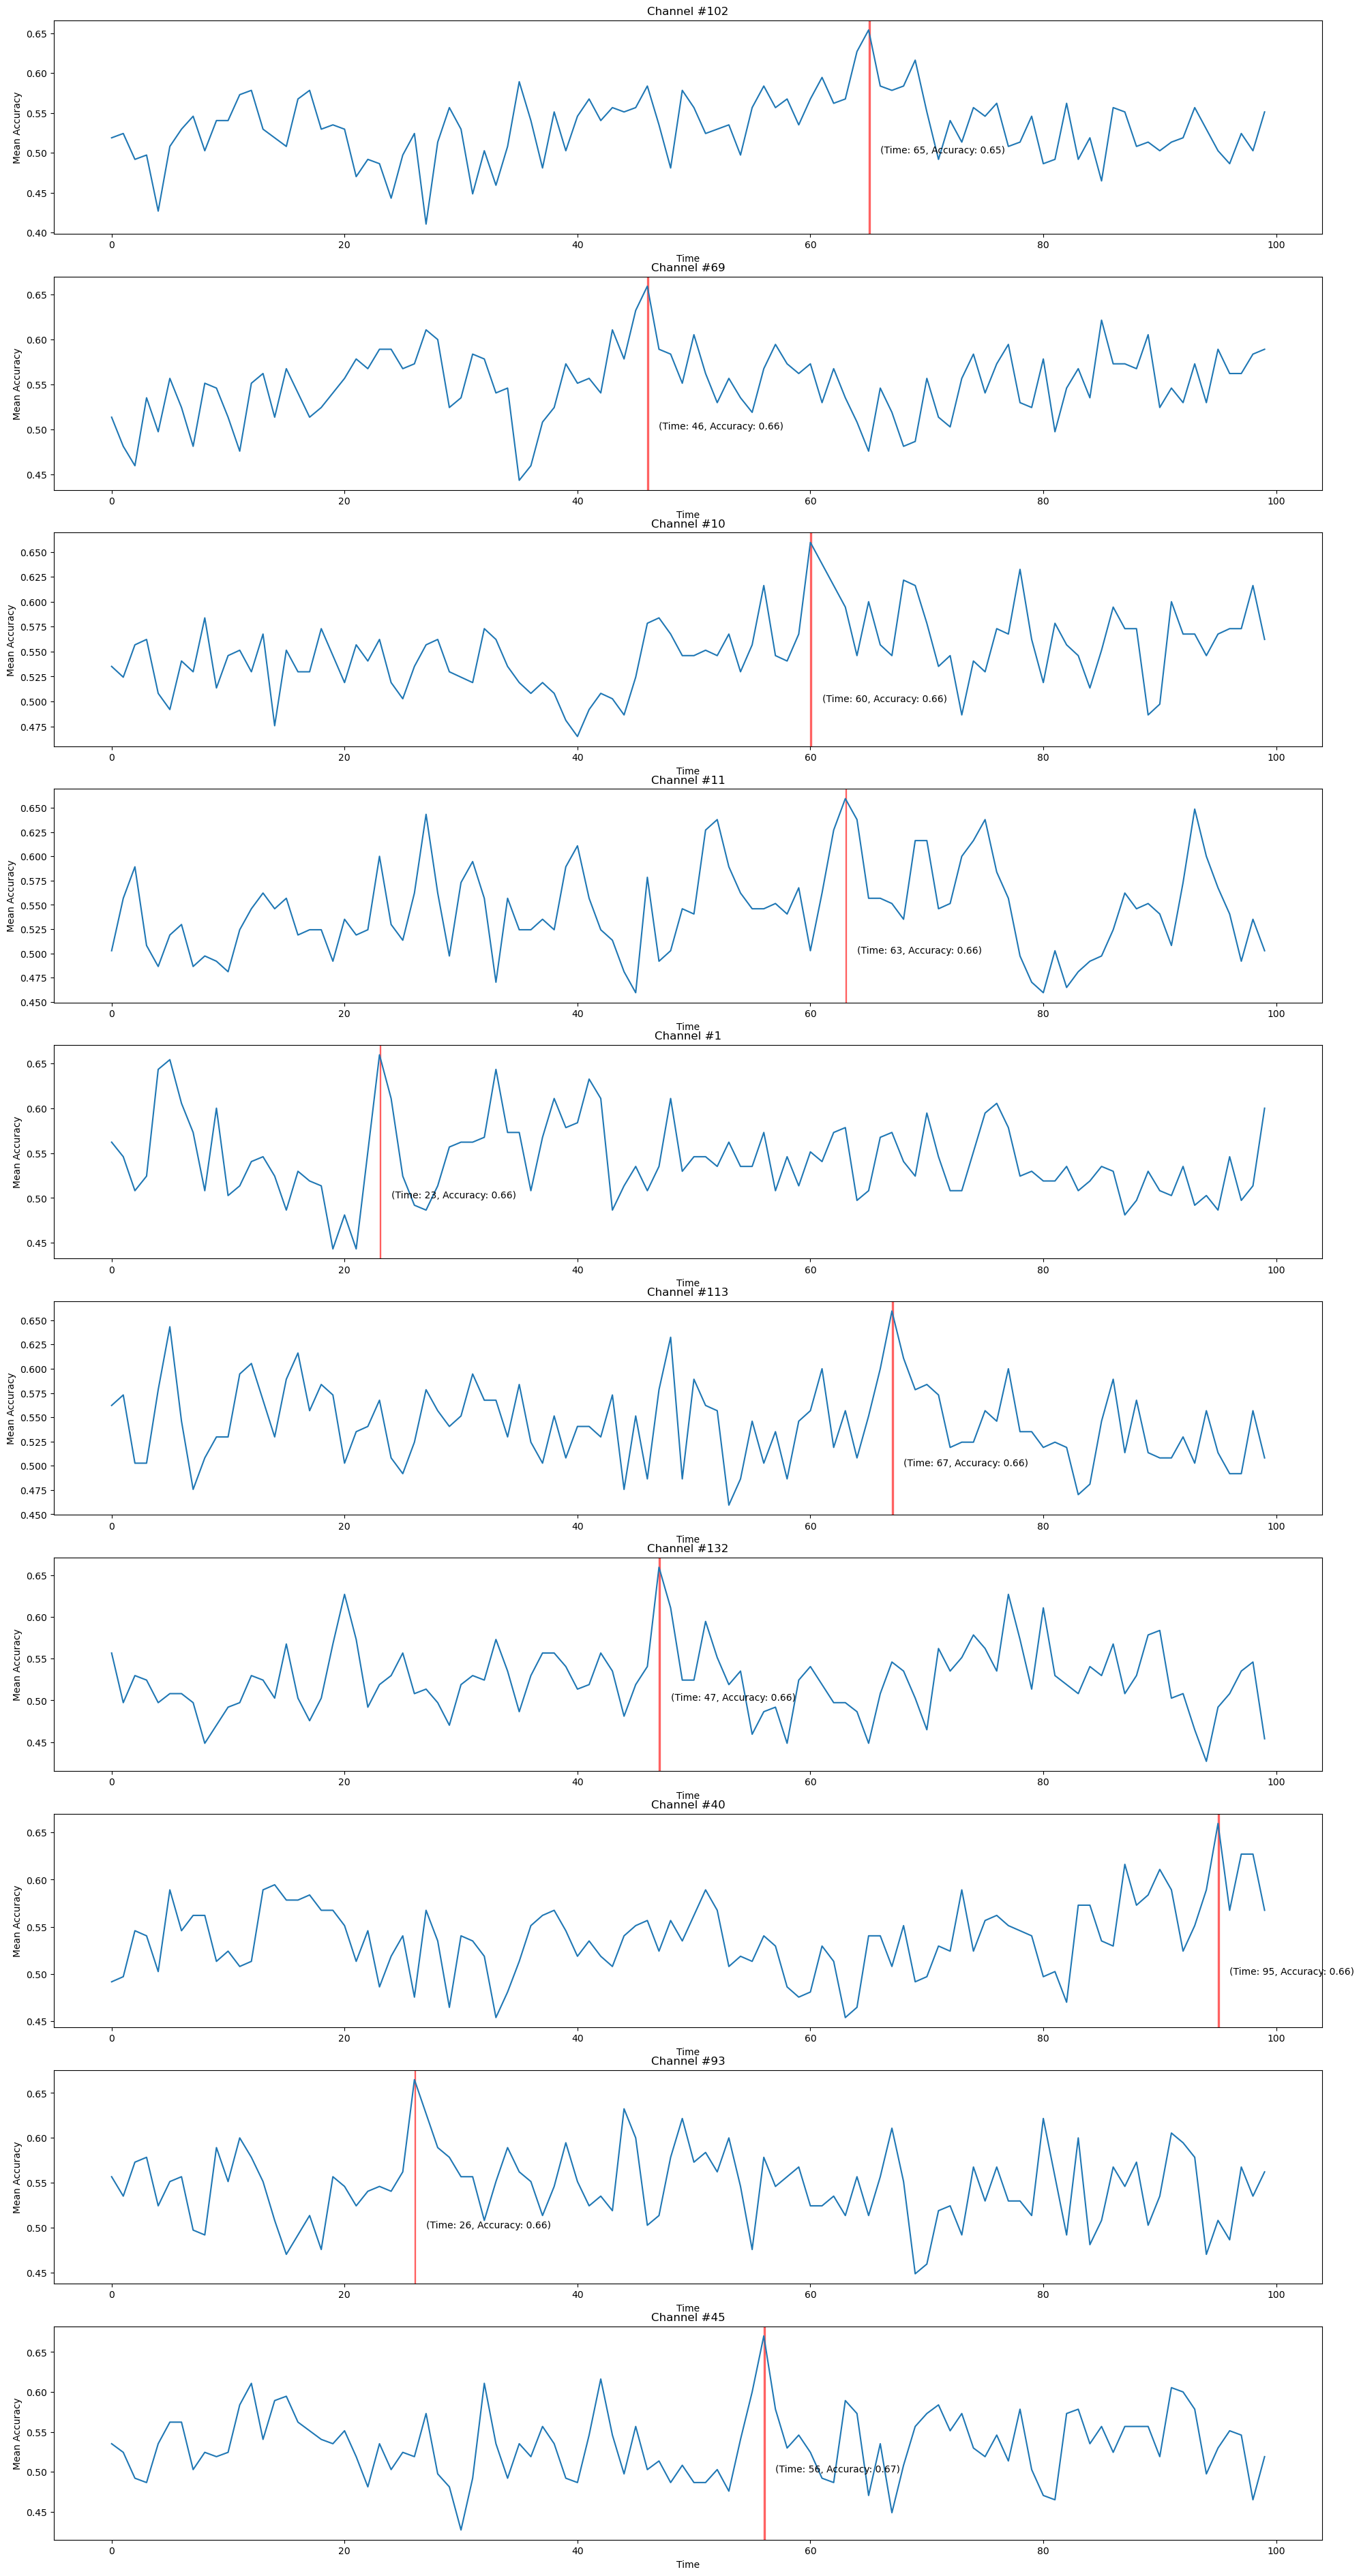

In [33]:
# Plot the mean accuracy vs time graph of the top 10 channels with the highest accuracy

fig, axs = plt.subplots(10, 1, figsize=(24, 48))

time = np.arange(0, 100, 1)

for i, channel in enumerate(top_ten_accuracies_index):
    ax = axs[i]
    ax.plot(time, mean_accuracies[channel])
    ax.set_title('Channel #%i' %(channel + 1))
    ax.set_ylabel('Mean Accuracy')
    ax.set_xlabel('Time')
    ax.axvspan(mean_accuracies_max[channel,1],mean_accuracies_max[channel,1]+.1,color = 'red', alpha=0.5)
    # ax.annotate('local max', xy=(40, .5))
    ax.annotate(f'(Time: {mean_accuracies_max[channel,1]:.0f}, Accuracy: {mean_accuracies_max[channel,0]:.2f})', xy=(mean_accuracies_max[channel,1] + 1,.5))

plt.savefig('top_ten_accuracies.png')
plt.show()

In [ ]:
plt.savefig('top_ten_accuracies.png')

## Covariance matrices

In [ ]:
import seaborn as sns

cov = np.cov(mean_accuracies)
sns.heatmap(cov)

In [ ]:
cov_max = np.zeros((num_channels,2))
cov_diag = np.zeros((num_channels))

for channel in range(num_channels):
    # cov_max[channel] = cov[channel].max() # Used to sanity check that cov_diag == cov_max
    cov_temp = cov[channel, np.arange(num_channels) != channel] # Get the entire row 
    cov_max[channel,0] = cov_temp.max()
    cov_max[channel,1] = int(list(cov_temp).index(cov_temp.max())) # Get the corresponding channel that has the highest covariance
    cov_diag[channel] = cov[channel,channel]

In [ ]:
# print(cov_diag)
# print(cov_max)
# print(cov[0,0])

# print(cov_diag==cov_max) # Used to sanity check that cov_diag == cov_max
# print(cov_max/cov_diag)

# print(cov_max[0])

cov_ratio = (cov_max[:,0]/cov_diag) # Get the ratios of the maximum value of the covariance (non-diagonal) to the value of the diagonal
cov_index = []

for i, covariance in enumerate(cov_ratio):
     if covariance > .5:
            cov_index.append(i)

print(cov_index)


In [ ]:
# Prints the mean accuracy vs time graphs of the channels with the highest covariance

fig, axs = plt.subplots(len(cov_index), 1, figsize=(24, 48))

time = np.arange(0, 100, 1)

for i, channel in enumerate(cov_index):
    ax = axs[i]
    ax.plot(time, mean_accuracies[channel])
    ax.set_title('Channel #%i' %(channel + 1))
    ax.set_ylabel('Mean Accuracy')
    ax.set_xlabel('Time')

plt.show()

# Extraneous Code

In [ ]:
# Sanity check that t_values make sense

print(mean_accuracies[0,15])
print(t_stats[0,:])

In [ ]:
#Trying to implement k-fold cross validation approach with RepeatedKFold 

from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits = 5, n_repeats=10, random_state=42)

for channel in range(133):
    for time in range(100):
        X = data[:, channel, :, time]
        fold_index = 0
        for train_index, test_index in rkf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
            lda.fit(X_train, y_train)

            if fold_index < 5:
                model_accuracies[channel, time, fold_index] = lda.score(X_test, y_test)

            fold_index += 1

In [ ]:
model_accuracies_na = model_accuracies

In [ ]:
model_accuracies_lsqr = model_accuracies

In [ ]:
model_accuracies_eigen = model_accuracies

In [ ]:
for i in range(133):
    print('Channel %i The accuracy for the model without regularization: %f' %(model_accuracies_na[i].mean()))
    print('Channel %i The accuracy for the model with regularization (lsqr): %f' %(model_accuracies_lsqr[i].mean()))
    print('Channel %i The accuracy for the model with regularization (eigen): %f' %(model_accuracies_eigen[i].mean()))